In [1]:
import numpy as np

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram, plot_state_city, plot_gate_map
import qiskit_aer.noise as noise

In [2]:
class ClassicalOracle:
    def __init__(self, secret: np.array):
        self.n = len(secret)
        self.count = 0
        self.secret = secret

    def complexity(self) -> int:
        return self.n

    def number_of_queries(self) -> int:
        return self.count

    def query(self, inp: np.array) -> bool:
        self.count += 1
        product = np.dot(self.secret, inp)
        return product % 2


def classical_bv_algorithm(oracle: ClassicalOracle) -> np.array:
    n = oracle.complexity()
    secret = np.zeros(n, dtype=np.byte)

    for i in range(n):
        inp = np.zeros(n, dtype=np.byte)
        inp[i] = 1

        if oracle.query(inp):
            secret[i] = 1

    return secret

In [115]:
# secret_str = list("01100110"+"01100110"+"01100110")
secret_str = list("11010101")

secret = np.array(secret_str, dtype=np.byte)
oracle = ClassicalOracle(secret)

solution = classical_bv_algorithm(oracle)

print("secret string:".ljust(20, " "), secret)
print("classical solution:".ljust(20, " "), solution)
print("match:".ljust(20, " "), np.array_equal(solution, secret))
print("# of queries:".ljust(20, " "), oracle.number_of_queries())

secret string:       [1 1 0 1 0 1 0 1]
classical solution:  [1 1 0 1 0 1 0 1]
match:               True
# of queries:        8


In [136]:
n = len(secret)

# query_reg = QuantumRegister(n, "query")
# auxiliary_reg = QuantumRegister(1, "auxiliary")
# oracle = QuantumCircuit(query_reg, auxiliary_reg, name="oracle")

# for i in range(n):
#     if secret[n - i - 1]:
#         oracle.cx(query_reg[i], auxiliary_reg[0])

# oracle.draw(output="mpl")

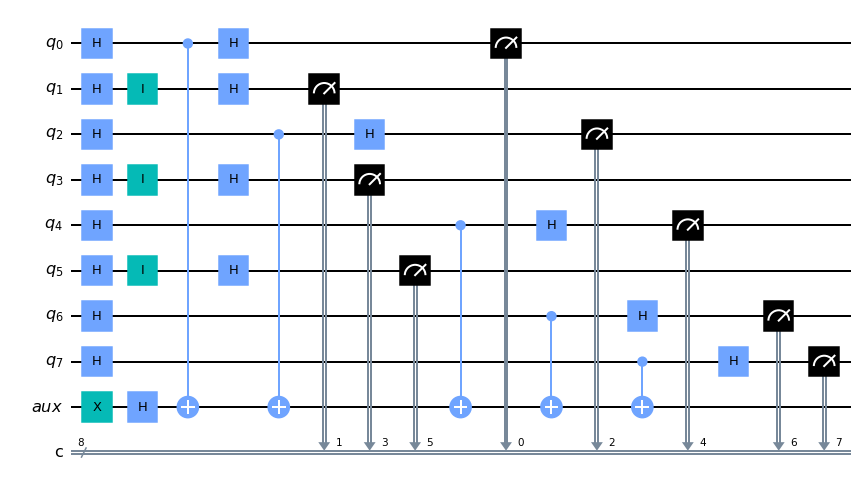

In [142]:
qr = QuantumRegister(n, "q")
cr = ClassicalRegister(n, "c")
aux = QuantumRegister(1, "aux")
qc = QuantumCircuit(qr, aux, cr)

qc.h(qr)
qc.x(aux)
qc.h(aux)

# qc.append(oracle, [*qr, aux])
for i in range(n):
    if secret[n - i - 1]:
        qc.cx(qr[i], aux[0])
    else:
        qc.i(qr[i])

qc.h(qr)

qc.measure(qr, cr)

qc.draw(output="mpl")

In [118]:
job = execute(qc, Aer.get_backend("qasm_simulator"), shots=1000)
counts = job.result().get_counts()

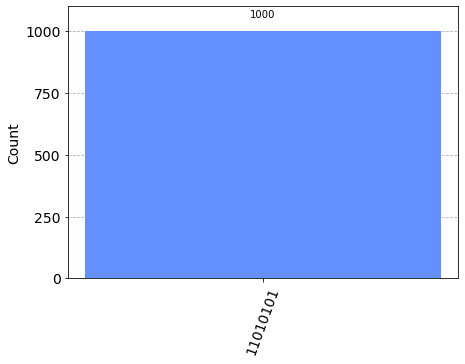

In [119]:
plot_histogram(counts)

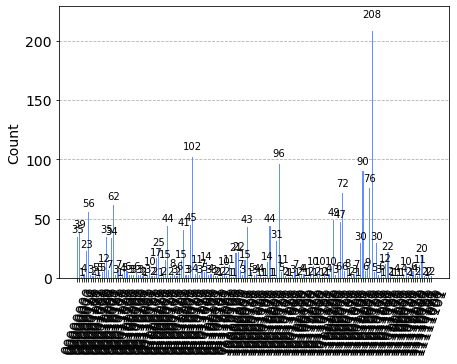

In [143]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)


# Error probabilities
prob_1 = 0.2  # 1-qubit gate
prob_2 = 0.2  # 2-qubit gate

p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ["h", "z", "x"])
noise_model.add_all_qubit_quantum_error(error_2, ["cx"])

noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
# noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# transpiled_qc = transpile(qc, qasm_simulator)
# Execute circuit and show results
ex = execute(
    qc,
    Aer.get_backend("qasm_simulator"),
    basis_gates=basis_gates,
    noise_model=noise_model,
    shots=2000
)
counts = ex.result().get_counts(qc)

plot_histogram(counts)

In [144]:
len(counts)

157

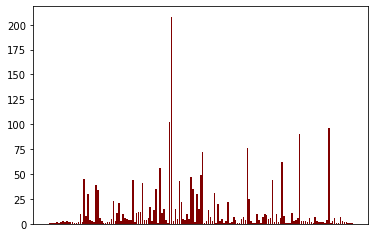

In [145]:
import matplotlib.pyplot as plt

# creating the dataset
courses = list(counts.keys())
values = list(counts.values())
  
# fig = plt.figure(figsize = (10, 5))
 
plt.bar(courses, values, color ='maroon')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.show()

In [14]:
simulator = QasmSimulator()
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1000)
result = job.result()
counts = result.get_counts(qc)
print("\nTotal count for 00 and 11 are:",counts)


Total count for 00 and 11 are: {'0010': 1000}


In [15]:
# !pip install qiskit-ibm-runtime

# from qiskit_ibm_runtime import QiskitRuntimeService

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="...")
# service = QiskitRuntimeService()

In [18]:
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy

# service = IBMQ.enable_account("")
print(service.backends())
backend = least_busy(service.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_nairobi') from I

In [20]:
transpiled_bv_circuit = transpile(qc, backend)

In [23]:


shots = 1024
job = backend.run(transpiled_bv_circuit, shots=shots)

from qiskit.tools.monitor import job_monitor
job_monitor(job, interval=2)

Job Status: job has successfully run


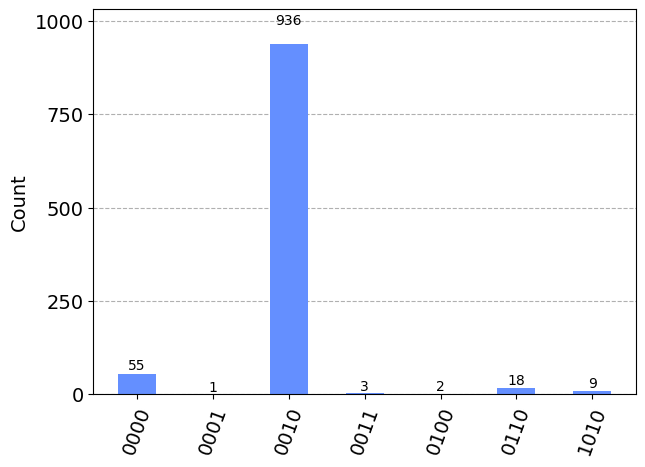

In [24]:
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

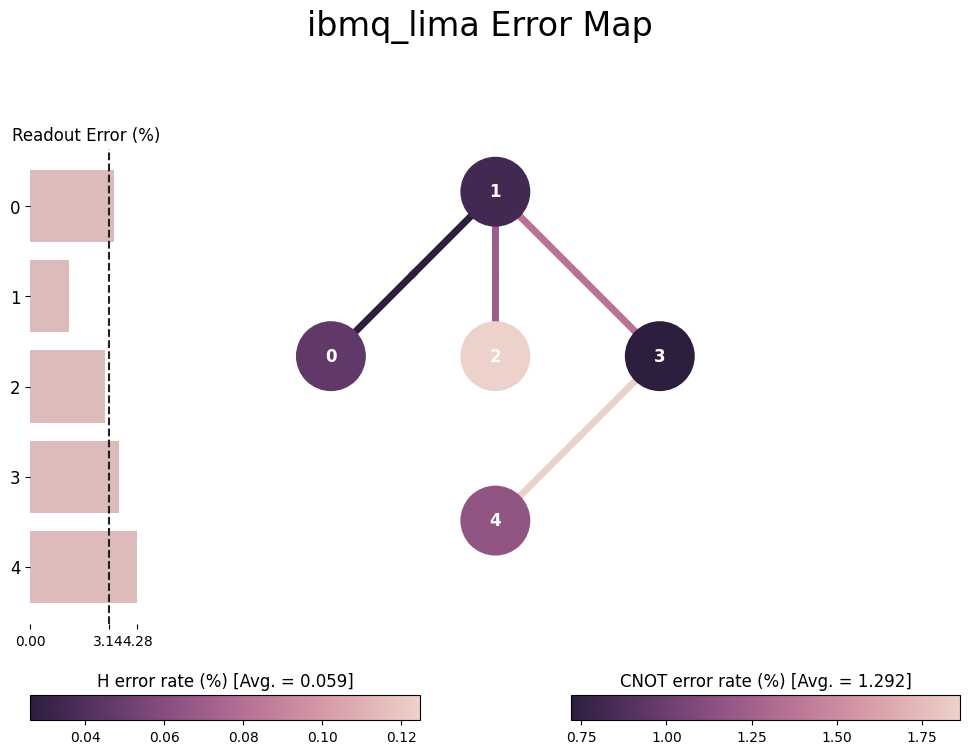

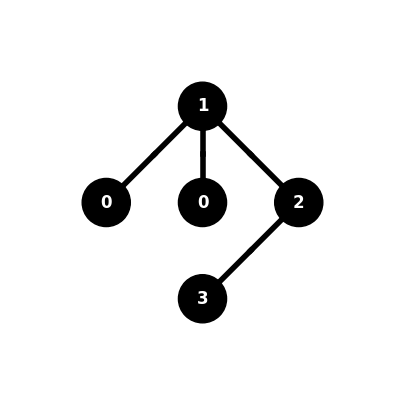

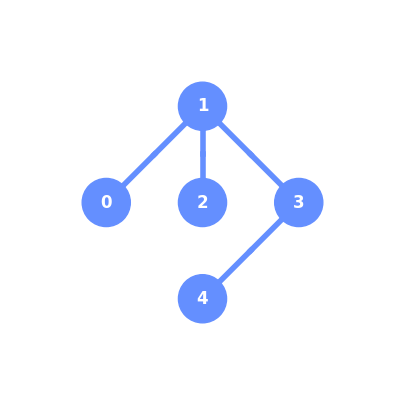

In [22]:
from qiskit.visualization import plot_error_map, plot_circuit_layout, plot_gate_map

display(plot_error_map(backend))
display(plot_circuit_layout(transpiled_bv_circuit, backend))
display(plot_gate_map(backend))